## 1.- Exploración de datos

In [1]:
# Importa librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [2]:
# Función para cargar datos con manejo de errores
def load_data(file_name):
    file_path = f"files/datasets/input/{file_name}"
    try:
        data = pd.read_csv(file_path)
        print(f"Data loaded successfully from {file_path}")
        return data
    except Exception as e:
        print(f"Error: File {file_path} not found.")
        return None

# Carga los datos
contract_data = load_data('contract.csv')
personal_data = load_data('personal.csv')
internet_data = load_data('internet.csv')
phone_data = load_data('phone.csv')

Data loaded successfully from files/datasets/input/contract.csv
Data loaded successfully from files/datasets/input/personal.csv
Data loaded successfully from files/datasets/input/internet.csv
Data loaded successfully from files/datasets/input/phone.csv


In [3]:
# Verifica si los datos se cargaron correctamente
if contract_data is not None and personal_data is not None and internet_data is not None and phone_data is not None:
    # Une los datos en un solo DataFrame
    merged_data = pd.merge(contract_data, personal_data, on='customerID', how='inner')
    merged_data = pd.merge(merged_data, internet_data, on='customerID', how='left')
    merged_data = pd.merge(merged_data, phone_data, on='customerID', how='left')

In [4]:
# Muestra información sobre los datos cargados
display(merged_data.info)

<bound method DataFrame.info of       customerID   BeginDate              EndDate            Type  \
0     7590-VHVEG  2020-01-01                   No  Month-to-month   
1     5575-GNVDE  2017-04-01                   No        One year   
2     3668-QPYBK  2019-10-01  2019-12-01 00:00:00  Month-to-month   
3     7795-CFOCW  2016-05-01                   No        One year   
4     9237-HQITU  2019-09-01  2019-11-01 00:00:00  Month-to-month   
...          ...         ...                  ...             ...   
7038  6840-RESVB  2018-02-01                   No        One year   
7039  2234-XADUH  2014-02-01                   No        One year   
7040  4801-JZAZL  2019-03-01                   No  Month-to-month   
7041  8361-LTMKD  2019-07-01  2019-11-01 00:00:00  Month-to-month   
7042  3186-AJIEK  2014-08-01                   No        Two year   

     PaperlessBilling              PaymentMethod  MonthlyCharges TotalCharges  \
0                 Yes           Electronic check          

In [5]:
# Visualiza una muestra del DataFrame merged_data
display(merged_data.head())

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


## 2.- Preprocesamiento de datos

In [6]:
# Elimina registros duplicados basados en el customerID
merged_data.drop_duplicates(subset='customerID', inplace=True)

In [7]:
# Manejo de fechas

# Convierte 'BeginDate' a tipo datetime
merged_data['BeginDate'] = pd.to_datetime(merged_data['BeginDate'])

# Reemplaza 'No' por NaN en la columna 'EndDate'
merged_data['EndDate'] = merged_data['EndDate'].replace('No', np.nan)

# Convierte a datetime y manejar errores 
merged_data['EndDate'] = pd.to_datetime(merged_data['EndDate'],  errors='coerce')

# Extrae solo la fecha de la columna 'EndDate'
merged_data['EndDate'] = merged_data['EndDate'].dt.date

In [8]:
# Calcula la duración del contrato en meses, ignorando las filas donde 'EndDate' es NaN
merged_data['ContractDuration'] = (pd.to_datetime(merged_data['EndDate']) - merged_data['BeginDate']).dt.days / 30

# Rellena valores NaN resultantes con 0 y convertir a entero    
merged_data['ContractDuration'] = merged_data['ContractDuration'].fillna(0).astype(int)

In [9]:
# Manejo de valores faltantes

# Rellena valores faltantes en 'MultipleLines' con 'No'
merged_data['MultipleLines'] = merged_data['MultipleLines'].fillna('No')  

# Convierte a numérico y manejar errores
merged_data['TotalCharges'] = pd.to_numeric(merged_data['TotalCharges'], errors='coerce')  

# Rellena valores NaN con 0
merged_data['TotalCharges'] = merged_data['TotalCharges'].fillna(0)  

In [10]:
# Convierte la columna SeniorCitizen a 'Yes' o 'No'
merged_data['SeniorCitizen'] = merged_data['SeniorCitizen'].map({0: 'No', 1: 'Yes'})

In [11]:
# Manejo de valores categóricos
categorical_cols = ['Type', 'PaperlessBilling', 'PaymentMethod', 'gender', 'Partner', 'Dependents', 
                        'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 
                        'StreamingTV', 'StreamingMovies']
for col in categorical_cols:
        merged_data[col] = merged_data[col].astype('category')

In [12]:
# Codificación de variables categóricas
encoded_data = pd.get_dummies(merged_data, columns=categorical_cols, drop_first=True)

# Divide los datos en features y target
X = encoded_data.drop(['customerID', 'EndDate'], axis=1)
y = encoded_data['EndDate']

In [13]:
# Divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Verifica las dimensiones de los conjuntos
print("Dimensiones del conjunto de entrenamiento (features):", X_train.shape)
print("Dimensiones del conjunto de prueba (features):", X_test.shape)
print("Dimensiones del conjunto de entrenamiento (target):", y_train.shape)
print("Dimensiones del conjunto de prueba (target):", y_test.shape)

Dimensiones del conjunto de entrenamiento (features): (5634, 22)
Dimensiones del conjunto de prueba (features): (1409, 22)
Dimensiones del conjunto de entrenamiento (target): (5634,)
Dimensiones del conjunto de prueba (target): (1409,)


In [24]:
# Visualiza una muestra del DataFrame merged_data
display(merged_data.head())

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,...,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,ContractDuration
0,7590-VHVEG,2020-01-01,NaT,Month-to-month,Yes,Electronic check,29.85,29.85,Female,No,...,No,DSL,No,Yes,No,No,No,No,No,0
1,5575-GNVDE,2017-04-01,NaT,One year,No,Mailed check,56.95,1889.50,Male,No,...,No,DSL,Yes,No,Yes,No,No,No,No,0
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,Male,No,...,No,DSL,Yes,Yes,No,No,No,No,No,2
3,7795-CFOCW,2016-05-01,NaT,One year,No,Bank transfer (automatic),42.30,1840.75,Male,No,...,No,DSL,Yes,No,Yes,Yes,No,No,No,0
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,Female,No,...,No,Fiber optic,No,No,No,No,No,No,No,2


## 3.- Análisis exploratorio de datos (EDA)

In [15]:
# Estadísticas descriptivas para características numéricas
print("\nEstadísticas descriptivas para características numéricas:")
print(merged_data.describe())


Estadísticas descriptivas para características numéricas:
                           BeginDate  MonthlyCharges  TotalCharges  \
count                           7043     7043.000000   7043.000000   
mean   2017-04-30 13:01:50.918642688       64.761692   2279.734304   
min              2013-10-01 00:00:00       18.250000      0.000000   
25%              2015-06-01 00:00:00       35.500000    398.550000   
50%              2017-09-01 00:00:00       70.350000   1394.550000   
75%              2019-04-01 00:00:00       89.850000   3786.600000   
max              2020-02-01 00:00:00      118.750000   8684.800000   
std                              NaN       30.090047   2266.794470   

       ContractDuration  
count       7043.000000  
mean           4.777794  
min            0.000000  
25%            0.000000  
50%            0.000000  
75%            1.000000  
max           73.000000  
std           12.848202  


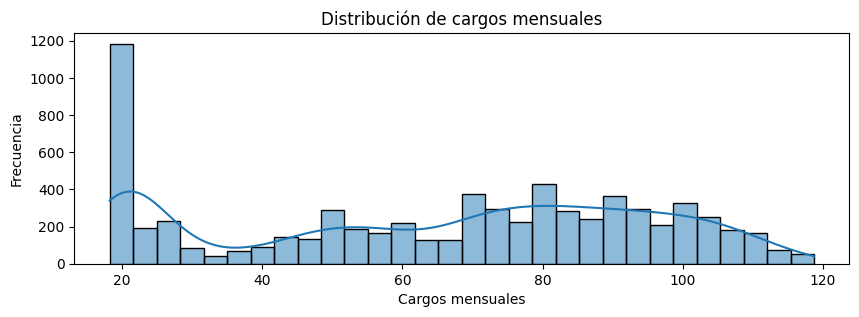

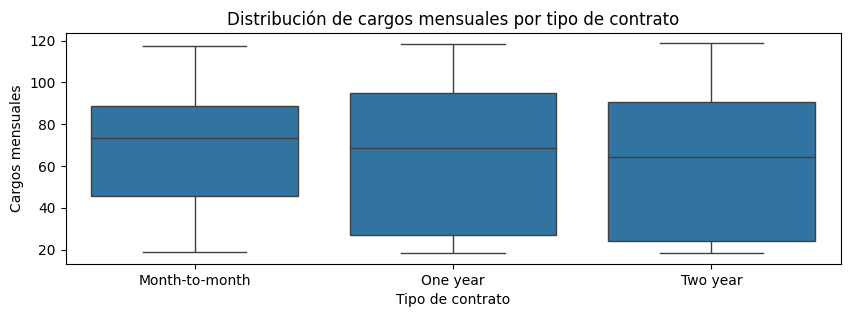

In [25]:
# Visualización de distribuciones
plt.figure(figsize=(10, 3))
sns.histplot(data=merged_data, x='MonthlyCharges', bins=30, kde=True)
plt.title('Distribución de cargos mensuales')
plt.xlabel('Cargos mensuales')
plt.ylabel('Frecuencia')
plt.show()

plt.figure(figsize=(10, 3))
sns.boxplot(data=merged_data, x='Type', y='MonthlyCharges')
plt.title('Distribución de cargos mensuales por tipo de contrato')
plt.xlabel('Tipo de contrato')
plt.ylabel('Cargos mensuales')
plt.show()

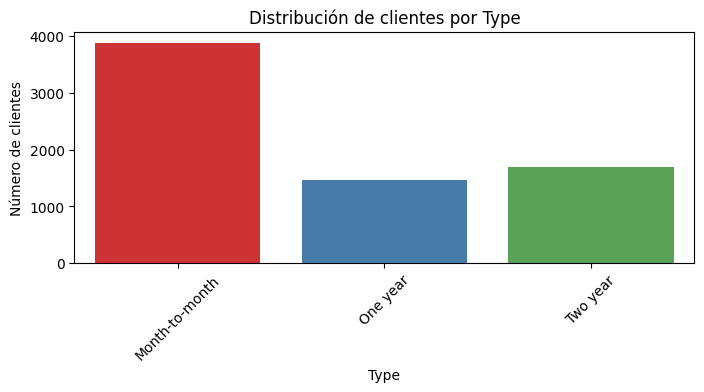

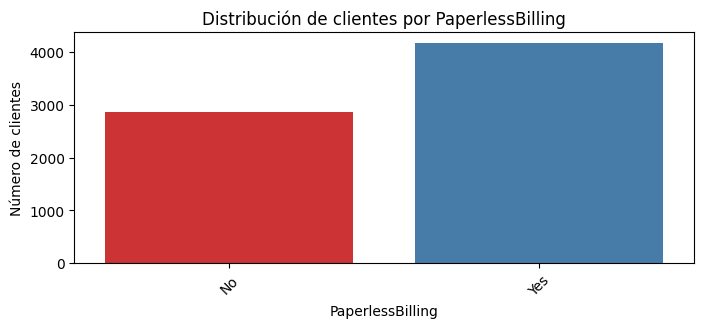

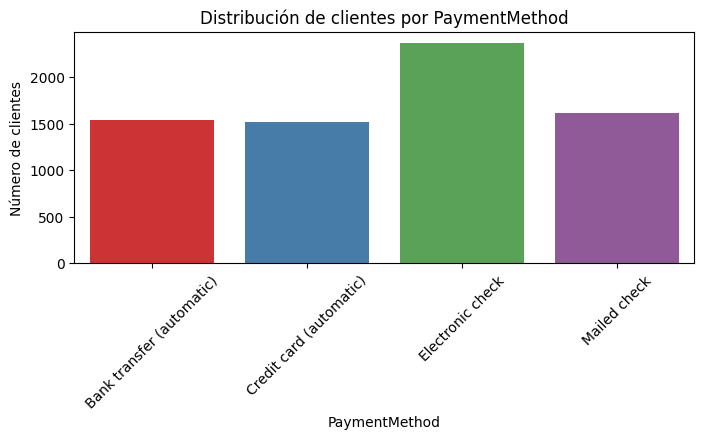

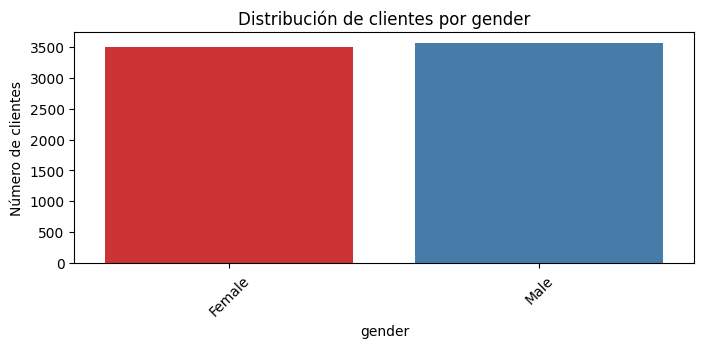

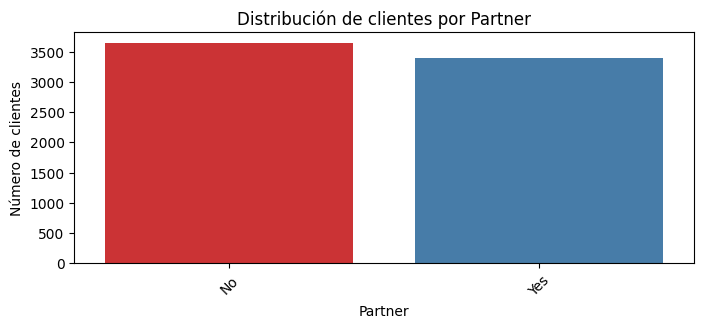

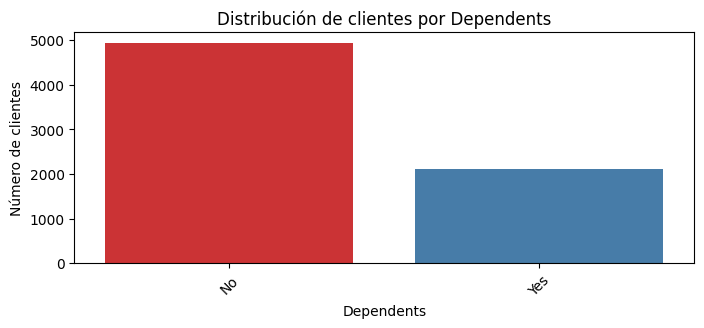

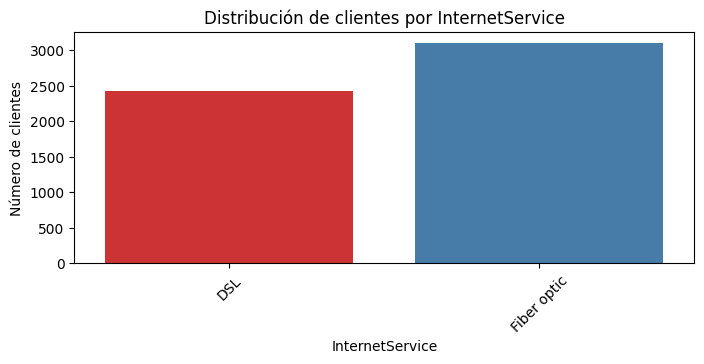

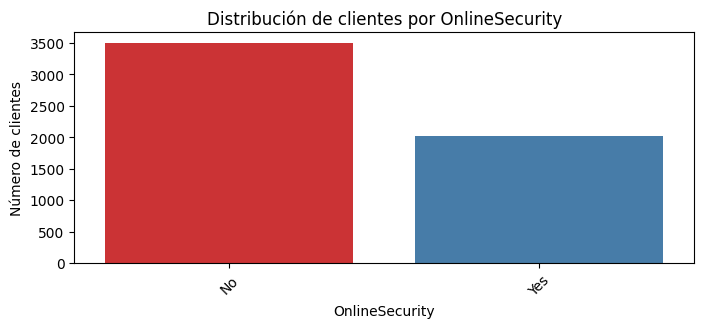

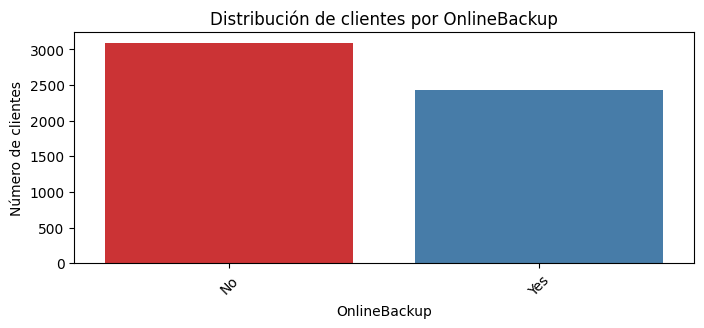

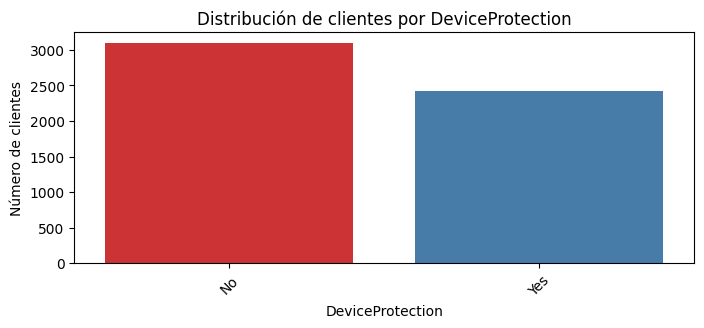

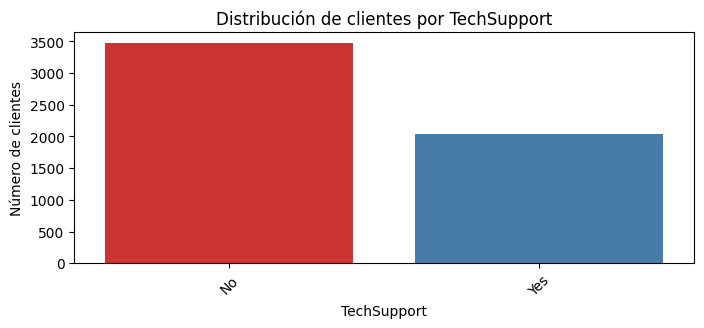

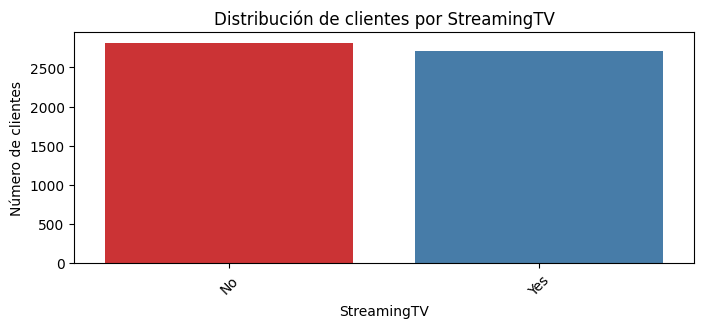

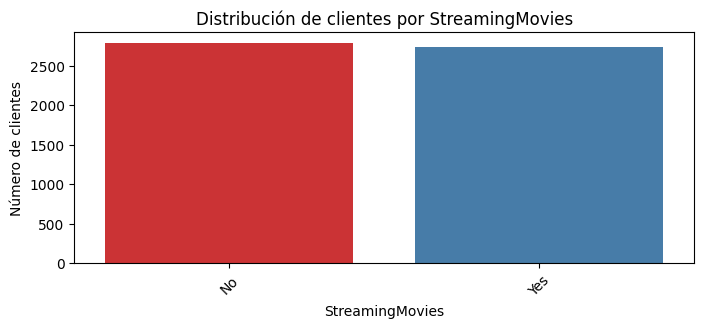

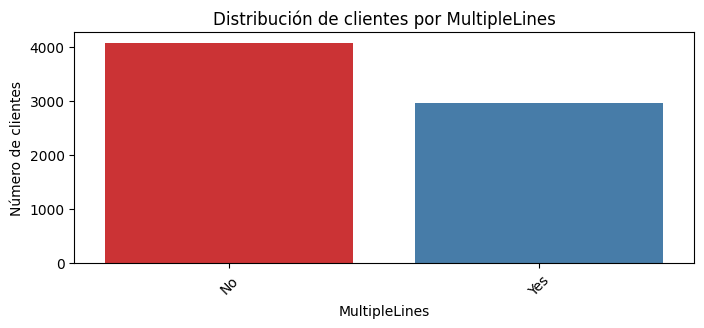

In [31]:
# Visualización de características categóricas
categorical_cols = ['Type', 'PaperlessBilling', 'PaymentMethod', 'gender', 'Partner', 'Dependents', 
                    'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 
                    'StreamingTV', 'StreamingMovies', 'MultipleLines']

for col in categorical_cols:
    plt.figure(figsize=(8, 3))
    sns.countplot(data=merged_data, x=col, hue=col, palette='Set1', legend=False)
    plt.title(f'Distribución de clientes por {col}')
    plt.xlabel(col)
    plt.ylabel('Número de clientes')
    plt.xticks(rotation=45)
    plt.show()

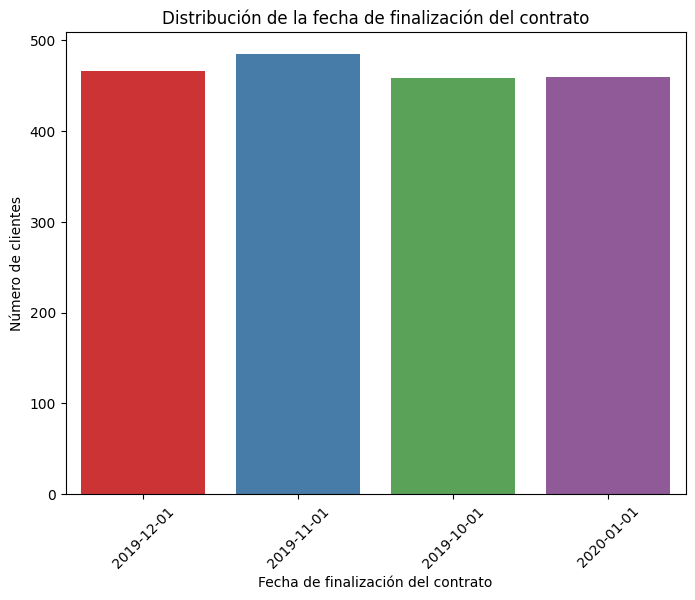

In [39]:
# Análisis de la variable objetivo
plt.figure(figsize=(8, 6))
sns.countplot(data=merged_data, x='EndDate', hue='EndDate', palette='Set1', legend=False)
plt.title('Distribución de la fecha de finalización del contrato')
plt.xlabel('Fecha de finalización del contrato')
plt.ylabel('Número de clientes')
plt.xticks(rotation=45)
plt.show()

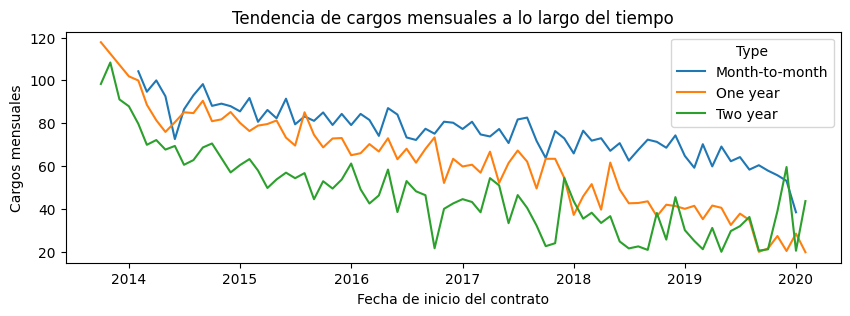

In [43]:
# Exploración de tendencias temporales
plt.figure(figsize=(10, 3))
sns.lineplot(data=merged_data, x='BeginDate', y='MonthlyCharges', hue='Type', errorbar=None)
plt.title('Tendencia de cargos mensuales a lo largo del tiempo')
plt.xlabel('Fecha de inicio del contrato')
plt.ylabel('Cargos mensuales')
plt.show()

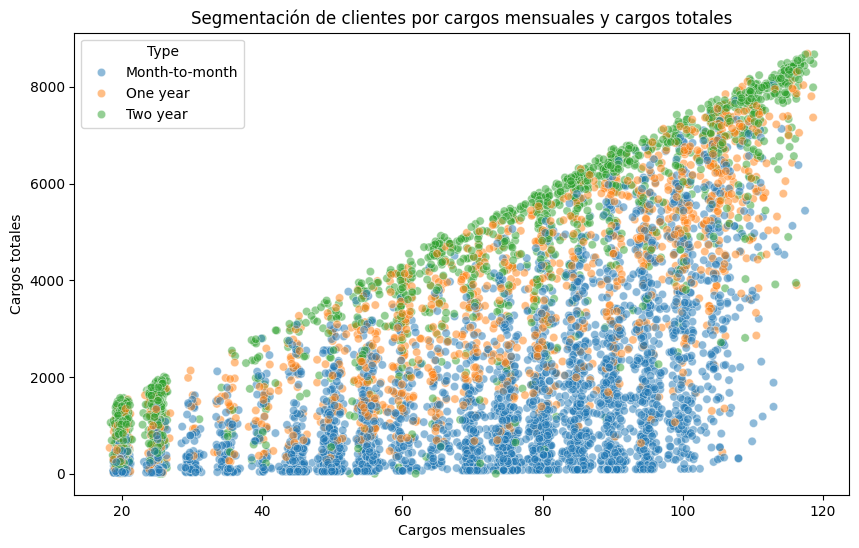

In [48]:
# Segmentación de clientes
plt.figure(figsize=(10, 6))
sns.scatterplot(data=merged_data, x='MonthlyCharges', y='TotalCharges', hue='Type', alpha=0.5)
plt.title('Segmentación de clientes por cargos mensuales y cargos totales')
plt.xlabel('Cargos mensuales')
plt.ylabel('Cargos totales')
plt.show()